**IMPORTING REQUIRED LIBRARIES**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import cv2
import pathlib
import glob
import shutil
import os
import random


**IMPORTING THE DATA**

In [2]:
######################################### caution : terminal commands #######################################################

#-------------------------------------empty the datasets forlder before downloading the dataset -------------------------------------

%cd
%cd .keras/datasets/
!rm -r *

/root
/root/.keras/datasets


In [3]:
########################################### download data from given url ###############################################3

dataset_url = "https://storage.googleapis.com/wandb_datasets/nature_12K.zip"
data_dir = tf.keras.utils.get_file('nature_12K', origin=dataset_url, extract=True)


3816693760/3816687935 [==============================] - 43s 0us/step


**SPLITTING THE DATA**

In [4]:
#---------------------------------------------caution : terminal commands ----------------------------------------------

%cd
%cd .keras/datasets/inaturalist_12K
%mv val test
!mkdir valid

/root
/root/.keras/datasets/inaturalist_12K


In [5]:
#################################### split train data into validation set and training set ###################################

data_folder = '/root/.keras/datasets/inaturalist_12K'
os.chdir(data_folder)

folder_names = ['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia' ]
for i in range(0,10):
  source = data_folder + "/train/" +folder_names[i]  
  orig_files = os.listdir(source)
  chosen_indexes = random.sample(range(0, len(orig_files)-1), 100)

  destination = data_folder + "/valid/"
  os.chdir(destination)
  os.system('mkdir'+' '+str(folder_names[i]))
  destination = destination + folder_names[i]
  for j in range(0,100):
    shutil.move(   source +"/" + str(   orig_files[   chosen_indexes[j]  ]   )  , destination)


In [6]:
####################################### Correcting the directory location ####################################################

data_dir = data_dir.split('/')
data_dir.remove('nature_12K')
data_dir.append('inaturalist_12K')
data_dir = '/'.join(data_dir)

In [7]:
#-------------------------------------Taking the train data--------------------------------------------------------
train_data_dir_path = data_dir + '/train'
train_data_dir = pathlib.Path(train_data_dir_path)

#--------------------------------------Taking the validation data-----------------------------------------------
valid_data_dir_path = data_dir + '/valid'
valid_data_dir = pathlib.Path(valid_data_dir_path)

#----------------------------------------Taking the test data-----------------------------------------------
test_data_dir_path = data_dir + '/test'
test_data_dir = pathlib.Path(test_data_dir_path)

In [8]:
#------------------------------------------Parameters for the images-------------------------------------------------
batch_size = 32
img_height = 180
img_width = 180

In [9]:
####################################### converting the image data into dataset ############################################

#-------------------------------------training dataset -----------------------------------------------------
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

#----------------------------------------------validation dataset -----------------------------------------------
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
  )

Found 8999 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


**CONVOLUTIONAL NEURAL NETWORK**

In [14]:
class CNN():

############################################# constructor for class CNN ##########################################
  def __init__(self, batch_size, img_height, img_width, filter_count, filter_size, active_func,dense_neurons_count,maxpool_size,output_neurons_count, optimizer='adam'):
    self.batch_size = batch_size
    self.img_height = img_height
    self.img_width = img_width
    self.filter_count = filter_count
    self.filter_size = filter_size
    self.active_func = active_func
    self.dense_neurons_count = dense_neurons_count
    self.maxpool_size = maxpool_size
    self.num_classes = output_neurons_count
    self.optimizer = optimizer
    self.model = self.create_model(5)


############################################### function to create model ####################################################
  def create_model(self, num_layers):

    #-------------------------------------------creating the CNN model -----------------------------------------------------

    layerslist = []
    #------------------Including a normalisation layer in the model---------------------------------------
    layerslist.append(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(self.img_height, self.img_width, 3)))

    #------------------Creating (convolution,activation,maxpool) layers in the model---------------------------------------
    for i in range(0,num_layers):
      layerslist.append(layers.Conv2D(self.filter_count[i], self.filter_size[i], padding='same', activation = self.active_func[i]))
      layerslist.append(layers.MaxPooling2D(pool_size = self.maxpool_size[i]))

    layerslist.append(layers.Flatten())
    layerslist.append(layers.Dense(self.dense_neurons_count,  activation = self.active_func[num_layers]))
    layerslist.append(layers.Dense(self.num_classes))

    model = Sequential(layerslist)

    # ---------------------------------------compiling the CNN model ----------------------------------------------------------
    model.compile(
    optimizer = self.optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'] )

    #--------------------------------------------- return final model --------------------------------------------------------
    return model 


  
############################################## function for training the model ##################################################3
  def train(self, train_ds, val_ds, epochs = 10):

    #------------------------------------caching the datasets -----------------------------------------------
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    #------------------------------------ training the model -----------------------------------------------
    history = self.model.fit( train_ds, validation_data=val_ds, epochs=epochs )
    return history

    


############################################ function for summary of model ###########################################3
  def model_summary(self):
    return self.model.summary()

#=============================================== end of class CNN ======================================================
    

In [15]:
############################################# function to visualize result ###########################################333#
def visualise_results(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [16]:
# (self, batch_size, img_height, img_width, num_filters, filter_size, active_func,dense_neurons_count,maxpool_size,output_neurons_count, optimizer='adam')
# train(self, train_ds, val_ds, epochs = 10)

batch_size = 32
img_height = 180
img_width = 180
filter_count = [16,32,64,64,64]
filter_size = [3,3,3,3,3]
maxpool_size = [2,2,2,2,2]
active_func = ['relu']*6
dense_neurons_count = 120
output_neurons_count = 10
epochs = 2

cnn = CNN(batch_size, img_height, img_width, filter_count, filter_size, active_func, dense_neurons_count, maxpool_size, output_neurons_count)

In [17]:
history = cnn.train(train_ds, val_ds, epochs)

Epoch 1/2
282/282 [==============================] - 364s 1s/step - loss: 2.2820 - accuracy: 0.1262 - val_loss: 2.2183 - val_accuracy: 0.1560
Epoch 2/2
282/282 [==============================] - 283s 1s/step - loss: 2.1772 - accuracy: 0.1875 - val_loss: 2.1479 - val_accuracy: 0.1980


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2 as IRV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.xception import Xception


from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Activation , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,  Model

import wandb


class ObjectDetection():

    def __init__(self, image_size, modelConfigDict, using_pretrained_model = False, base_model = "IRV2" ):
        
        self.no_hidden_cnn_layers= modelConfigDict["no_hidden_cnn_layers"]
        self.activation = modelConfigDict["activation"]
        self.batch_norm = modelConfigDict["batch_norm"]
        self.filter_dist = modelConfigDict["filter_dist"]
        self.filter_size = modelConfigDict["filter_size"]
        self.no_of_filters_base  = modelConfigDict["no_of_filters_base"]
        self.dropout_fraction = modelConfigDict["dropout_fraction"]
        self.pool_size = modelConfigDict["pool_size"]
        self.padding = modelConfigDict["padding"]
        self.dense_neurons = modelConfigDict["dense_neurons"]
        self.num_classes = modelConfigDict["num_classes"]
        self.optimizer = modelConfigDict["optimizer"]
        self.global_avg_pooling = modelConfigDict["global_avg_pooling"]
        self.batch_normalisation_location = modelConfigDict["batch_normalisation_location"]
        BASE_MODELS = {
        "IRV2" : IRV2,
        "IV3" : InceptionV3,
        "RN50" : ResNet50,
        "XCPTN" : Xception
        }      
        
        if using_pretrained_model == True:
            self.base_model = base_model

            if self.base_model == "RN50":
                self.IMG_HEIGHT = 224
                self.IMG_WIDTH = 224

            else:
                self.IMG_HEIGHT = image_size[0]
                self.IMG_WIDTH = image_size[1]        

        self.IMG_HEIGHT = image_size[0]
        self.IMG_WIDTH = image_size[1]        
         
        self.input_shape = (self.IMG_HEIGHT, self.IMG_WIDTH, 3)

    def build_cnnmodel_dense(self):

        with tf.device('/device:GPU:0'):
            tf.keras.backend.clear_session()
            model = Sequential()
            
            #Input Layer
            model.add(Conv2D(self.no_of_filters_base, self.filter_size ,kernel_initializer = "he_uniform",padding = self.padding,input_shape = (self.IMG_HEIGHT, self.IMG_WIDTH, 3)))
            if self.batch_normalisation_location == "Before" and self.batch_norm: model.add(BatchNormalization())
            model.add(Activation(self.activation))
            
            #Performing Batch_normalisation
            if self.batch_normalisation_location == "After" and self.batch_norm: model.add(BatchNormalization())
            
            #Max pooling
            model.add(MaxPooling2D(pool_size=self.pool_size))  
            for i in range(self.no_hidden_cnn_layers-1):
            
                ## Standard filter 
                if self.filter_dist == "standard":
                    model.add(Conv2D(self.no_of_filters_base, self.filter_size,kernel_initializer = "he_uniform",padding = self.padding))
            
                ## Double filter 
                elif self.filter_dist == "double":
                    model.add(Conv2D(2**(i+1)*self.no_of_filters_base, self.filter_size,kernel_initializer = "he_uniform",padding = self.padding))
            
                ## Half the filter size in each of the convolutional layers
                elif self.filter_dist == "half":
                    model.add(Conv2D(int(self.no_of_filters_base/2**(i+1)),self.filter_size, kernel_initializer = "he_uniform"))
            
                if self.batch_normalisation_location == "Before" and self.batch_norm: model.add(BatchNormalization())
                model.add(Activation(self.activation))
            
                if self.batch_normalisation_location == "After" and self.batch_norm: model.add(BatchNormalization())
                
                model.add(MaxPooling2D(pool_size=self.pool_size))
            
            #Densely connected layers
            if self.global_avg_pooling == True:
                model.add(GlobalAveragePooling2D())
            else:
                model.add(Flatten())
            model.add(Dense(self.dense_neurons, activation = 'sigmoid'))
            if self.dropout_fraction != None:
                model.add(tf.keras.layers.Dropout(self.dropout_fraction))
            model.add(Dense(self.num_classes, activation = 'softmax'))
          
            return model 

    def build_cnnmodel_conv(self):
        with tf.device('/device:GPU:0'):
            tf.keras.backend.clear_session()
            model = Sequential()
            
            #First CNN layer connecting to input layer
            model.add(Conv2D(self.no_of_filters_base, self.filter_size, padding = self.padding,kernel_initializer = "he_uniform", input_shape = (self.IMG_HEIGHT, self.IMG_WIDTH, 3)))
            if self.batch_normalisation_location == "Before" and self.batch_norm: model.add(BatchNormalization())
            model.add(Activation(self.activation))
            
            #batch_normalisation
            if self.batch_normalisation_location == "After" and self.batch_norm: model.add(BatchNormalization())
            #max pooling
            model.add(MaxPooling2D(pool_size=self.pool_size))  
            if self.dropout_fraction != None:
                model.add(tf.keras.layers.Dropout(self.dropout_fraction))
            for i in range(self.no_hidden_cnn_layers-1):
                #i+2th Convolutional Layer
            
                ## Standard filter distribution - same number of filters in all Convolutional layers
                if self.filter_dist == "standard":
                    model.add(Conv2D(self.no_of_filters_base, self.filter_size,kernel_initializer = "he_uniform",padding = self.padding))
            
                ## Double filter distribution - double number of filters in each Convolutional layers
                elif self.filter_dist == "double":
                    model.add(Conv2D(2**(i+1)*self.no_of_filters_base, self.filter_size,kernel_initializer = "he_uniform", padding = self.padding))
            
                ## Halve the filter size in each successive convolutional layers
                elif self.filter_dist == "half":
                    model.add(Conv2D(int(self.no_of_filters_base/2**(i+1)), self.filter_size,kernel_initializer = "he_uniform", padding = self.padding))
            
                if self.batch_normalisation_location == "Before" and self.batch_norm: model.add(BatchNormalization())
                model.add(Activation(self.activation))
            
                if self.batch_normalisation_location == "After" and self.batch_norm: model.add(BatchNormalization())
            
                model.add(MaxPooling2D(pool_size=self.pool_size))
                if self.dropout_fraction != None:
                    model.add(tf.keras.layers.Dropout(self.dropout_fraction))
            
            #Final densely connected layers
            if self.global_avg_pooling == True:
                model.add(GlobalAveragePooling2D())
            else:
                model.add(Flatten())

            model.add(Dense(self.dense_neurons, activation = 'sigmoid'))
            model.add(Dense(self.num_classes, activation = 'softmax'))

            return model      
        
    def build_cnnmodel_all(self):

        with tf.device('/device:GPU:0'):    
            tf.keras.backend.clear_session()
            model = Sequential()
            
            #First CNN layer
            model.add(Conv2D(self.no_of_filters_base, self.filter_size, padding = self.padding,kernel_initializer = "he_uniform", input_shape = (self.IMG_HEIGHT, self.IMG_WIDTH, 3)))
            model.add(Activation(self.activation))
            
            #Batch_normalisation
            if self.batch_normalisation_location == "After" and self.batch_norm: model.add(BatchNormalization())
            
            #Max pooling
            model.add(MaxPooling2D(pool_size=self.pool_size))  
            if self.dropout_fraction != None:
                model.add(tf.keras.layers.Dropout(self.dropout_fraction))

            for i in range(self.no_hidden_cnn_layers-1):
            
                ## Standard filter distribution
                if self.filter_dist == "standard":
                    model.add(Conv2D(self.no_of_filters_base, self.filter_size,kernel_initializer = "he_uniform", padding = self.padding))
            
                ## Double filter distribution
                elif self.filter_dist == "double":
                    model.add(Conv2D(2**(i+1)*self.no_of_filters_base, self.filter_size,kernel_initializer = "he_uniform",padding = self.padding))
            
                ## Halve the filter size in each successive convolutional layers
                elif self.filter_dist == "half":
                    model.add(Conv2D(int(self.no_of_filters_base/2**(i+1)), self.filter_size,kernel_initializer = "he_uniform", padding = self.padding))
            
                model.add(Activation(self.activation))
            
                if self.batch_normalisation_location == "After" and self.batch_norm: model.add(BatchNormalization())
            
                model.add(MaxPooling2D(pool_size=self.pool_size))
                if self.dropout_fraction != None:
                    model.add(tf.keras.layers.Dropout(self.dropout_fraction))
            
            #Densely connected layers
            if self.global_avg_pooling == True:
                model.add(GlobalAveragePooling2D())
            else:
                model.add(Flatten())

            model.add(Dense(self.dense_neurons, activation = 'sigmoid'))
            if self.dropout_fraction != None:
                model.add(tf.keras.layers.Dropout(self.dropout_fraction))
            model.add(Dense(self.num_classes, activation = 'softmax'))
            
            return model      
      
    
                 
        
    def load_pretrained_model(self):
        
        base_model = BASE_MODELS[self.base_model_name]
        base = base_model(weights='imagenet', include_top=False)
        x = base.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(self.dense_neurons, activation='relu')(x)
        guess = Dense(self.num_classes, activation='softmax')(x)
        model = Model(inputs=base.input, outputs=guess)

        # freeze the base layers
        for l in base.layers:
            l.trainable = False

        return model
 

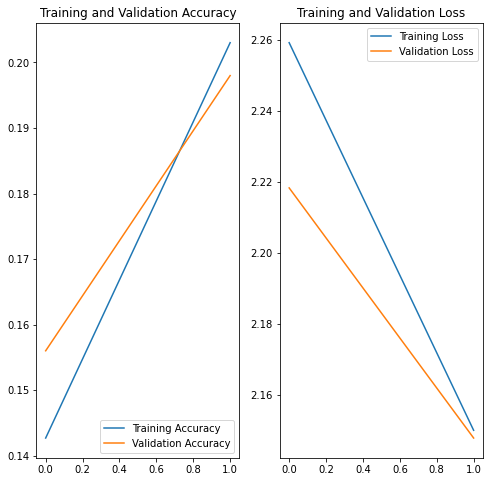

In [18]:
#------------------------------------visualising the results -----------------------------------------------
visualise_results(history, epochs)